In [261]:
import numpy as np 
import pandas as pd
import pickle,os
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
import sys
sys.path.append("..")
from nets import Nets
from utils import *

import re

from sklearn.cluster import DBSCAN


from postprocessing import *
from analysis import *

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [92]:
exp_root = "/Users/daniellengyel/flat_sharp/flat_sharp/experiments/{}" #"/Users/daniellengyel/flat_sharp/gaussian/gaussian_experiments/Apr03_17-38-00_Daniels-MacBook-Pro-4.local"
# configs = get_configs(experiment_folder)

In [103]:
experiment_folder = exp_root.format("MNIST/Apr19_22-59-17_Daniels-MacBook-Pro-4.local")

two_sampling = get_stuff(experiment_folder)
two_models = get_all_models(experiment_folder, -1)
two_resampling_idx = get_sample_idxs(experiment_folder)

1587329968.469613
1587329968.46856
1587329968.469613
1587329968.46856


In [4]:
experiment_folder = exp_root.format("MNIST/Apr20_03-37-18_Daniels-MacBook-Pro-4.local")
no_sampling = get_stuff(experiment_folder)
no_models = get_all_models(experiment_folder, -1)

1587346647.882677


In [5]:

experiment_folder = exp_root.format("MNIST/Apr22_01-53-27_Daniels-MacBook-Pro-4.local")
kish_lower_stuff = get_stuff(experiment_folder)
kish_lower_models = get_all_models(experiment_folder, -1)

1587513216.9390788
1587513217.363613
1587513215.967423
1587513216.469122


In [69]:

experiment_folder = exp_root.format("MNIST/Apr22_01-53-58_Daniels-MacBook-Pro-4.local")
more_stuff = get_stuff(experiment_folder)
more_models = get_all_models(experiment_folder, -1)

1587513260.341572
1587513258.1924942
1587513267.032066
1587513264.4261959
1587513261.812853
1587513263.2589061
1587513265.730539
1587513258.653904
1587513268.094351
1587513269.228578


In [173]:

experiment_folder = exp_root.format("CIFAR10/Apr24_22-20-23_Daniels-MacBook-Pro-4.local")
CIFAR10_stuff = get_stuff(experiment_folder)
CIFAR10_models = get_all_models(experiment_folder, -1)
CIFAR10_resampling_idx = get_sample_idxs(experiment_folder)

1587759639.9299772
1587759639.714095
1587759639.9299772
1587759639.714095


In [207]:


experiment_folder = exp_root.format("FashionMNIST/Apr26_19-42-22_Daniels-MacBook-Pro-4.local")
fashion_stuff = get_stuff(experiment_folder)
fashion_models = get_all_models(experiment_folder, -1)
fashion_resampling_idx = get_sample_idxs(experiment_folder)

Error: tsne could not be found
Error: runs could not be found
Error: trace could not be found
1587922951.9470038
1587922951.816041
1587922951.815885
1587922951.9470038
1587922951.816041
1587922951.815885


In [257]:
# get all sorts of data
exp_dict = {}

experiment_folder = exp_root.format("FashionMNIST/Apr27_00-03-27_Daniels-MacBook-Pro-4.local")
exp_dict["stuff"] = get_stuff(experiment_folder)
exp_dict["models"] = get_all_models(experiment_folder, -1)
exp_dict["resampling_idxs"] = get_sample_idxs(experiment_folder)

1587969731.521131
1587959691.3295202
1587959771.2839198
1587938682.237956
1587979969.839093
1587949916.310493
1587979978.0448792
1587979863.996534
1587979752.008478
1587949901.417682
1587979875.9594638
1587979762.577444
1587959680.130168
1587938676.958861
1587949851.291446
1587949952.543494
1587938668.618131
1587959718.445655
1587979679.813218
1587969642.196658
1587969665.7071118
1587949851.510209
1587979950.331296
1587949904.895765
1587938675.3940868
1587959776.781079
1587980060.502008
1587959724.059208
1587959802.4893582
1587938678.520759
1587969614.3948228
1587950011.623552
1587949897.7914429
1587949874.0319622
1587979966.486805
1587959691.356412
1587938674.130773
1587938684.189412
1587938670.7361999
1587949881.584672
1587969718.0564501
1587959717.2117991
1587969637.918807
1587969725.9068859
1587969555.326112
1587979959.526977
1587938669.357399
1587938680.006163
1587969760.3500469
1587949838.352247
1587969725.874828
1587959769.9323468
1587938685.4067688
1587938672.734766
1587959802.

In [270]:
stats_df = get_end_stats(exp_dict["stuff"], ["learning_rate", "batch_train_size", "softmax_beta"], {"softmax_beta":0})
stats_df.sort_values(by="Mean Test Acc", ascending=False)


,,,Mean Std Trace,Mean Test Acc,Mean Trace,Mean Train Loss,Test Acc/Trace Correlation,Train Loss/Trace Correlation
0.421632,128,0,5.108050,0.890000,27.649789,0.194319,-0.998722,-0.367454
0.369053,128,0,3.985783,0.876667,27.610197,0.209487,-0.955610,-0.278504
0.684526,128,0,5.463909,0.876667,23.863805,0.172499,-0.524813,-0.805467
0.631947,128,0,5.025798,0.876667,26.132166,0.179371,-0.938434,-0.467051
0.474211,128,0,4.751749,0.876667,27.794165,0.198997,-0.886385,-0.355652
0.789684,128,0,4.112320,0.876667,22.564009,0.157192,-0.234367,0.550897
0.579368,128,0,4.345401,0.873333,24.532815,0.196615,-0.768940,-0.480792
0.106158,128,0,16.269896,0.873333,41.549845,0.313692,-0.427640,0.808183
0.737105,128,0,4.019600,0.873333,21.499106,0.178355,0.782440,0.951076
0.526789,128,0,5.990123,0.873333,27.445437,0.198126,-0.518591,0.158448


In [323]:
import itertools

def _get_plot_values(exp_dict, X_axis, Y_axis, filter_dict={}):
    stat_names = ["Mean Std Trace", "Mean Test Acc", "Mean Trace", "Mean Train Loss", "Test Acc/Trace Correlation", "Train Loss/Trace Correlation"]
    key_label_names = []
    
    if X_axis not in stat_names:
        key_label_names.append(X_axis)
    if Y_axis not in stat_names:
        key_label_names.append(Y_axis)

    stats_df = get_end_stats(exp_dict["stuff"], key_label_names, filter_dict)
    
    X_values = []
    Y_values = []
    
    for idx, row in stats_df.iterrows():
        if X_axis not in stat_names:
            X_values.append(float(idx[0]))
        else:
            X_values.append(float(row[X_axis]))
        if Y_axis not in stat_names:
            Y_values.append(float(idx[-1]))
        else:
            Y_values.append(float(row[Y_axis]))
    return X_values, Y_values

def plot_end_stats(exp_dict, X_axis, Y_axis, filter_dict={}, X_axis_bounds=None, Y_axis_bounds=None):
    
    plots = []
    plots_names = []
    
    # get template filter_dict which does not neeed to be iterated
    # get keys which do need to be iterated 
    template_filter_dict = {}
    grid_search_keys = []
    grid_search_values = []
    for k in filter_dict:
        k_split = k.split(":")
        if k_split[-1] == "special":
            grid_search_keys.append(k_split[0])
            grid_search_values.append(filter_dict[k])
        else:
            template_filter_dict[k] = filter_dict[k]
            
    # do grid search over the ones which do need to be iterated
    if len(grid_search_keys) != 0:
        for c in itertools.product(*grid_search_values):
            curr_plt_name = []
            for i in range(len(grid_search_keys)):
                template_filter_dict[grid_search_keys[i]] = c[i]
                curr_plt_name.append("{}:{} ".format(grid_search_keys[i], c[i]))

            X_values, Y_values = _get_plot_values(exp_dict, X_axis, Y_axis, filter_dict=template_filter_dict)
            plots.append(plt.scatter(X_values, Y_values))
            plots_names.append("".join(curr_plt_name)[:-1])
    else:
        X_values, Y_values = _get_plot_values(exp_dict, X_axis, Y_axis, filter_dict=template_filter_dict)
        plots.append(plt.scatter(X_values, Y_values))
        plots_names.append("")
        
    
    
    plt.legend(tuple(plots),
       plots_names,
       scatterpoints=1,
       loc='lower left',
       ncol=3,
       fontsize=8)
    
    plt.xlabel(X_axis)
    plt.ylabel(Y_axis)
    if X_axis_bounds is not None:
        plt.xlim(X_axis_bounds) 
    if Y_axis_bounds is not None:
        plt.ylim(Y_axis_bounds)    
    
    plt.show()

    
    


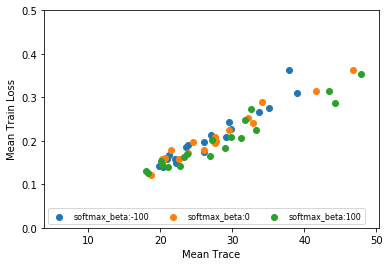

In [330]:
plot_end_stats(exp_dict, X_axis="Mean Trace", Y_axis="Mean Train Loss", filter_dict={"softmax_beta:special": [-100, 0, 100]}, Y_axis_bounds=(0, 0.5))


1587759639.9299772
No Potential/curr for step 5000


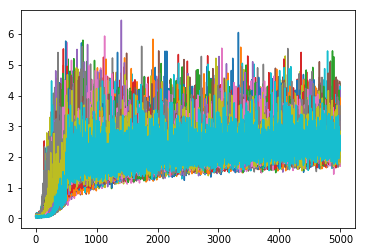

1587759639.714095
No Potential/curr for step 5000


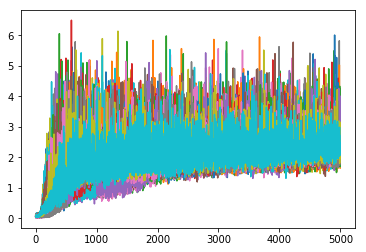

NameError: name 'tmp_list' is not defined

In [206]:
stuff = CIFAR10_stuff

def get_runs_plots(exp_dict, var_name="Kish"):
    exp_runs = exp_dict["stuff"]["runs"]
    for i in exp_runs:
        
        plot_list = []

        print(i)

        for step in sorted(exp_runs[i], key=lambda x: int(x)):
            try:
                # going down the tree with node names given by var_name.split("/")
                curr_dict = exp_runs[i][step]
                var_name_split = var_name.split("/")
                for n in var_name_split:
                    curr_dict = curr_dict[n]
                    
                if "net" in curr_dict:
                    num_nets = int(max(curr_dict["net"], key=lambda x: int(x))) + 1 # +1 bc zero indexed
                    to_append = [curr_dict["net"][str(nn)] for nn in range(num_nets)]
                else:
                    to_append = curr_dict[""]
                plot_list.append(to_append)
            except:
                print("No {} for step {}".format(var_name, step))
        plt.plot(plot_list)
        plt.show()
            
    return tmp_list

# kish = get_runs_plot(stuff["runs"], ["Kish"])
# weight_var_trace = get_runs_plot(stuff["runs"], ["WeightVarTrace"])

weight_var_trace = get_runs_plots(exp_dict, "Potential/curr")



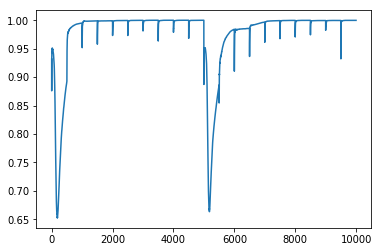

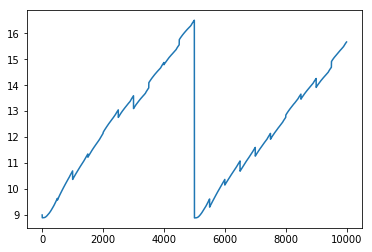

In [177]:
plt.plot(kish)
plt.show()

plt.plot(weight_var_trace)
plt.show()

In [242]:

def plot_analysis(exp_dict, X_axis, Y_axis):

    marker_list = ["o", "v", "^", "<", ">", "1", "2", "3", "4", "8", "s", "p", "P", "*", "h", "H", "+", "x", "X", "D", "d", "|", "_"]



    stuff = exp_dict["stuff"]
    run_data = stuff["runs"]
    trace = stuff["trace"]
    
    
    for exp_id in stuff["configs"]:
        plots = []
        plots_names = []
                
        num_nets = stuff["configs"][exp_id]["num_nets"]
        num_steps = max(run_data[exp_id], key=lambda x: int(x))

        beta = stuff["configs"][exp_id]["softmax_beta"]

        print(beta)

        models = exp_dict["models"][exp_id] #CIFAR10_models
        models_vecs = np.array([get_params_vec(models[str(nn)]).detach().numpy() for nn in range(num_nets)])
        
        clustering = DBSCAN(eps=5, min_samples=2).fit(models_vecs)
        l = clustering.labels_



#         Y = [run_data[i][4999]["Potential"]["total"]["net"][str(nn)] for nn in range(50)]
    #     Y = [eigs[i][str(nn)][0][0] for nn in range(50)]
        Y = np.array([np.mean(trace[exp_id][str(nn)]) for nn in range(num_nets)])

#         X = np.array([run_data[id_exp][4999]["Loss"]["train"]["net"][str(nn)] for nn in range(50)])
        X = np.array([run_data[exp_id][num_steps]["Accuracy"]["net"][str(nn)] for nn in range(num_nets)])

#         last_sampling_step = sorted(two_resampling_idx[id_exp], key=lambda x: int(x))[-2]
#         last_resamples = two_resampling_idx[id_exp][last_sampling_step]
#         res_idx_to_marker = {res_idx: marker_list[i] for i, res_idx in enumerate(set(last_resamples))}

        label_set = set(l)
#         for l in range(50):
#             plots_names.append(l[nn])
#             plots.append(plt.scatter(X[nn], Y[nn], marker="o"))#res_idx_to_marker[last_resamples[nn]])
        for label in label_set:
            plots_names.append(label)
            plots.append(plt.scatter(X[l == label], Y[l == label], marker="o"))#res_idx_to_marker[last_resamples[nn]])


        plt.legend(tuple(plots),
               plots_names,
               scatterpoints=1,
               loc='lower left',
               ncol=3,
               fontsize=8)



        plt.xlabel("loss")
        plt.ylabel("trace")

        plt.show()

50


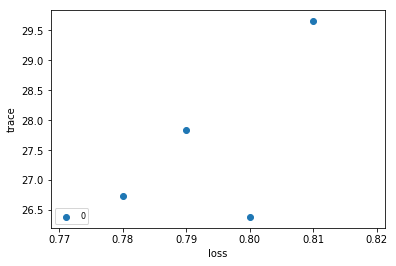

-50


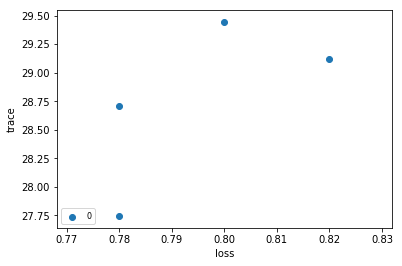

0


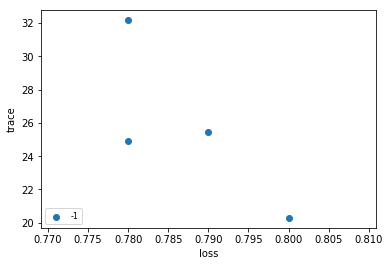

In [243]:
plot_analysis(exp_dict)

some analysis of final distance... 

show low loss path between. distance. what else?

# Analysis 

Plots (FUNCTION):
ACC vs Trace
Train Loss vs Trace
ACC vs Train loss
Mean/COV ACC -- MEAN/COV TRACE -- MEAN/COV TRAIN LOSS (CORRELATIONS FOR ALL OF THESE)


Plot weightspace and input space 

In [124]:
plots_names = []
plots = []

for r_data in [CIFAR10_stuff]:
    for i in r_data:
        
        try:
            beta = configs[i]["softmax_beta"]
        except:
            beta = 0
        plots_names.append(str(beta))
               
        run_data = r_data[0]
        trace = r_data[1]

        Y = [run_data[i][4999]["Potential"]["total"]["net"][str(nn)] for nn in range(50)]
    #     Y = [eigs[i][str(nn)][0][0] for nn in range(50)]
        Y = [np.mean(trace[i][str(nn)]) for nn in range(50)]

        X = [run_data[i][4999]["Loss"]["train"]["net"][str(nn)] for nn in range(50)]
#         X = [run_data[i][5000]["Accuracy"]["net"][str(nn)] for nn in range(50)]

        plots.append(plt.scatter(np.array(X), np.array(Y)))

        
plt.legend(tuple(plots),
       plots_names,
       scatterpoints=1,
       loc='lower left',
       ncol=3,
       fontsize=8)



plt.xlabel("loss")
plt.ylabel("trace")

plt.show()



KeyError: 0

(array([7., 3., 6., 5., 4., 6., 2., 1., 1., 1.]),
 array([ 89.99026489,  98.92023621, 107.85020752, 116.78017883,
        125.71015015, 134.64012146, 143.57009277, 152.50006409,
        161.4300354 , 170.36000671, 179.28997803]),
 <a list of 10 Patch objects>)

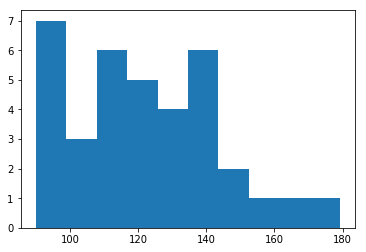

In [77]:
a = [127.37311553955078, 97.93885803222656, 158.1538848876953, 132.8297119140625, 116.41229248046875, 112.09640502929688, 131.17662048339844, 140.27606201171875, 104.38414764404297, 155.23452758789062, 136.9343719482422, 130.11436462402344, 121.89076232910156, 97.82975006103516, 121.72054290771484, 104.34451293945312, 169.51600646972656, 91.82275390625, 134.81613159179688, 136.09010314941406, 98.46024322509766, 121.43125915527344, 88.79573059082031, 118.9525146484375, 106.84197998046875, 93.86476135253906, 166.26219177246094, 111.35343170166016, 133.33021545410156, 107.85846710205078, 111.2021255493164, 125.52880859375]
a = [148.1651153564453, 89.99545288085938, 143.13145446777344, 129.59164428710938, 133.98138427734375, 179.28997802734375, 139.3506317138672, 90.68531036376953, 107.76986694335938, 121.02605438232422, 135.69696044921875, 101.74652099609375, 115.87667083740234, 122.7598648071289, 92.99028015136719, 165.59707641601562, 118.77754211425781, 90.56055450439453, 116.37315368652344, 113.5857162475586, 89.99026489257812, 136.0908203125, 90.26911163330078, 147.79518127441406, 137.81057739257812, 156.77203369140625, 118.10494232177734, 98.78507995605469, 133.88307189941406, 110.46347045898438, 113.26660919189453, 140.4408721923828, 99.68799591064453, 126.61418151855469, 113.37327575683594, 119.75435638427734]
plt.hist(a)

(50,)
[542.9575805664062, 600.6249389648438, 534.30419921875, 553.8997802734375, 542.3204345703125, 695.7343139648438, 568.3363037109375, 559.5490112304688, 621.9464721679688, 564.6443481445312, 519.8447265625, 521.8214721679688, 515.1004638671875, 609.952392578125, 537.172607421875, 616.8250732421875, 509.0643310546875, 635.6880493164062, 471.21484375, 577.85107421875, 549.3336791992188, 599.1685180664062, 587.0655517578125, 695.5125732421875, 562.3419189453125]

(-50,)
[468.0771179199219, 457.67218017578125, 510.1174011230469, 474.34967041015625, 574.97021484375, 486.2344665527344, 606.5770874023438, 497.95318603515625, 487.2482604980469, 620.97802734375, 531.549560546875, 475.3292236328125, 438.49078369140625, 439.6686706542969, 546.5634765625, 573.0172119140625, 548.7708740234375, 514.002685546875]



,Mean Std Trace,Mean Test Acc,Mean Trace,Mean Train Loss,Test Acc/Trace Correlation,Train Loss/Trace Correlation
50,54.889864,0.5996,581.138967,0.869805,0.173417,-0.026742
-50,56.388127,0.6072,527.883488,0.925043,0.138459,-0.366431


In [175]:
# next step, get accuracy here... sucks we can't get it otherwise

In [171]:
configs = get_configs(experiment_folder)
config_to_id_map = get_config_to_id_map(configs)
ids = get_ids(config_to_id_map, config)

NameError: name 'config' is not defined

In [161]:
config = {'batch_test_size': 100,
 'batch_train_size': 16,
 'ess_threshold': None,
 'learning_rate': 0.001,
 'momentum': 0,
 'net_name': 'SimpleNet',
 'net_params': None, #[2, 2, 256, 1],
 'num_steps': 100,
 'num_nets': 100,
 'softmax_beta': None, #0,
 'torch_random_seed': 1,
 'sampling_tau': None,
 'weight_type': 'loss_gradient_weights'}

In [ ]:
import time

In [ ]:
for i in sorted(tsne_dict):
    print(i)
    plt.scatter(tsne_dict[i][:, 0], tsne_dict[i][:, 1])
    plt.show()
    

In [ ]:
tsne_dict = get_tsne_dict(experiment_folder, curr_dir)
for i in sorted(tsne_dict):
    print(i)
    plt.scatter(tsne_dict[i][:, 0], tsne_dict[i][:, 1])
    plt.show()

In [ ]:


models, sampled_idx = get_models(os.path.join(experiment_folder, "resampling", curr_dir), 0)
models_vecs = np.array([get_params_vec(m) for m in models.values()])

shortest_distance = float("inf")
shortest_pair = (None, None)

largest_distance = -float("inf")
largest_pair = (None, None)
for i in range(len(models_vecs)):
    for j in range(i + 1, len(models_vecs)):
        if np.linalg.norm(models_vecs[i] - models_vecs[j]) < shortest_distance:
            shortest_distance = np.linalg.norm(models_vecs[i] - models_vecs[j])
            shortest_pair = (i, j)
        if np.linalg.norm(models_vecs[i] - models_vecs[j]) > largest_distance:
            largest_distance = np.linalg.norm(models_vecs[i] - models_vecs[j])
            largest_pair = (i, j)


In [ ]:
shortest_distance

In [ ]:
largest_distance
np.linalg.norm(models_vecs[0])

In [ ]:
with open(os.path.join(experiment_folder, "data.pkl"), "rb") as f:
    data = pickle.load(f)

train_loader = DataLoader(data[0], batch_size=len(data[0]), shuffle=True)  # fix the batch size
test_loader = DataLoader(data[1], batch_size=len(data[1]))

largest_arr = []
largest_acc = []
shortest_arr = []
shortest_acc = []

largest_mags = []
shortest_mags = []

step_dir = get_all_model_steps(os.path.join(experiment_folder, "resampling", curr_dir))
for step in sorted(step_dir):
    print(step)
    models, sampled_idx = get_models(os.path.join(experiment_folder, "resampling", curr_dir), step)
    models_vecs = np.array([get_params_vec(m) for m in models.values()])
    
    largest_arr.append(np.linalg.norm(models_vecs[largest_pair[0]] - models_vecs[largest_pair[1]]))
    shortest_arr.append(np.linalg.norm(models_vecs[shortest_pair[0]] - models_vecs[shortest_pair[1]]))
    
    largest_acc.append([get_net_accuracy(models[str(largest_pair[0])], test_loader), get_net_accuracy(models[str(largest_pair[1])], test_loader)])
    shortest_acc.append([get_net_accuracy(models[str(shortest_pair[0])], test_loader), get_net_accuracy(models[str(shortest_pair[1])], test_loader)])


    largest_mags.append([np.linalg.norm(models_vecs[largest_pair[0]]), np.linalg.norm(models_vecs[largest_pair[1]])])
    shortest_mags.append([np.linalg.norm(models_vecs[shortest_pair[0]]),np.linalg.norm(models_vecs[shortest_pair[1]])])

In [ ]:
plt.plot(list(sorted(step_dir)), largest_arr )
plt.show()
plt.plot(list(sorted(step_dir)), np.array(largest_acc)[:, 0])
plt.plot(list(sorted(step_dir)), np.array(largest_acc)[:, 1])
plt.show()

plt.plot(list(sorted(step_dir)), np.array(shortest_acc)[:, 0])
plt.plot(list(sorted(step_dir)), np.array(shortest_acc)[:, 1])
plt.show()


plt.plot(list(sorted(step_dir)), np.array(largest_mags)[:, 0])
plt.plot(list(sorted(step_dir)), np.array(largest_mags)[:, 1])
plt.show()

plt.plot(list(sorted(step_dir)), np.array(shortest_mags)[:, 0])
plt.plot(list(sorted(step_dir)), np.array(shortest_mags)[:, 1])
plt.show()

In [90]:


all_dist = {}
for i in range(len(models)):
    for j in range(i+1, len(models)):
        a = get_params_vec(models[str(i)])
        b = get_params_vec(models[str(j)])

        all_dist[(i, j)] = torch.norm(a - b)

In [91]:
all_dist

{(0, 1): tensor(16.6315, grad_fn=<NormBackward0>),
 (0, 2): tensor(16.6316, grad_fn=<NormBackward0>),
 (0, 3): tensor(0.0025, grad_fn=<NormBackward0>),
 (0, 4): tensor(16.6317, grad_fn=<NormBackward0>),
 (0, 5): tensor(0.0025, grad_fn=<NormBackward0>),
 (0, 6): tensor(16.6316, grad_fn=<NormBackward0>),
 (0, 7): tensor(0.0040, grad_fn=<NormBackward0>),
 (0, 8): tensor(16.6316, grad_fn=<NormBackward0>),
 (0, 9): tensor(0.0032, grad_fn=<NormBackward0>),
 (0, 10): tensor(16.6316, grad_fn=<NormBackward0>),
 (0, 11): tensor(16.6316, grad_fn=<NormBackward0>),
 (0, 12): tensor(16.6316, grad_fn=<NormBackward0>),
 (0, 13): tensor(16.6316, grad_fn=<NormBackward0>),
 (0, 14): tensor(16.6316, grad_fn=<NormBackward0>),
 (0, 15): tensor(16.6316, grad_fn=<NormBackward0>),
 (0, 16): tensor(16.6316, grad_fn=<NormBackward0>),
 (0, 17): tensor(16.6316, grad_fn=<NormBackward0>),
 (0, 18): tensor(0.0022, grad_fn=<NormBackward0>),
 (0, 19): tensor(16.6315, grad_fn=<NormBackward0>),
 (0, 20): tensor(0.0025, g

In [94]:
models_vecs = np.array([get_params_vec(m).detach().numpy() for m in models.values()])

X_embedded = TSNE(n_components=2).fit_transform(models_vecs)

[]

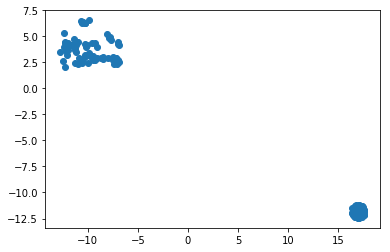

In [96]:
plt.scatter(X_embedded[:, 0], X_embedded[:, 1])
plt.plot()

In [109]:
m = models[str(0)]
grad_steps= []
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)  # fix the batch size

for data in train_loader:
    inputs, labels = data
    # Compute gradients for input.
    inputs.requires_grad = True

    # forward + backward + optimize
    outputs = m(inputs)
    loss = criterion(outputs.float(), labels)
    loss.backward(retain_graph=True)
    
    grad_steps.append(get_grad_params_vec(m).detach().numpy())

In [110]:
u, s, vh = np.linalg.svd(np.array(grad_steps), full_matrices=False)

array([7.4566307e+01, 4.2778692e+00, 3.0374603e+00, 9.4402808e-01,
       3.5643500e-01, 2.0473388e-01, 1.5873392e-01, 1.1142698e-01,
       9.3603715e-02, 7.8027248e-02, 6.5044165e-02, 6.0796760e-02,
       4.8285898e-02, 3.8336921e-02, 3.6647409e-02, 3.3087600e-02,
       2.9207643e-02, 2.3398781e-02, 2.1899553e-02, 2.1008376e-02,
       1.7819939e-02, 1.6101249e-02, 1.4436195e-02, 1.2744365e-02,
       1.1394381e-02, 1.0279431e-02, 9.7109778e-03, 9.3411161e-03,
       8.4276162e-03, 8.1074052e-03, 7.4696536e-03, 6.8786601e-03],
      dtype=float32)

In [ ]:
mnist_data = get_